In [2]:
cd C:\Users\augus\Google Drive\AI

C:\Users\augus\Google Drive\AI


In [3]:
import numpy as np
import os
import IPython.display as ipd
import pandas as pd
import soundfile as sf
from tqdm import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()

C:\Users\augus\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\augus\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\augus\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


# Bird call extraction logic
bandpass, then calculate power of initial segment $n^2$. Calculate power of each subsequent segment $A_i^2$, then calculate signal to noise ratio $\frac{A_i^2}{n_2}$ of each window, when the linear SNR is above a certain quantity, say that a signal has been detected.

In [4]:
from scipy.signal import butter, lfilter, freqz

def butter_filter(lo_bound, hi_bound, r, order=5):
    nyquist = 0.5 * r
    l = lo_bound / nyquist
    h = hi_bound / nyquist
    b, a = butter(order, [l, h], btype='band', analog=False)
    return b, a

def bandpass(
    x: np.array, 
    r: int=32000, 
    lo_bound: float = 2500, 
    hi_bound: float = 6000,
    order: int=5
):
    """
    Source https://www.allaboutbirds.org/news/do-bird-songs-have-frequencies-higher-than-humans-can-hear/
    Bird calls generally range from 1k-10k. Setting the lo and high bounds to 2500 and 6000 allows most of the range
    to be captured in the bandpass when considering the filter rollof at the boundaries.
    
    Args:
    x: input audio signal
    r: audio signal sampling rate in hz
    lo_bound: high pass boundary
    hi_bound: low pass boundary
    order: filter_order
    
    """
    b, a = butter_filter(lo_bound, hi_bound, r, order=order)
    filtered_data = lfilter(b, a, x)
    return filtered_data

def filter_and_detect_call(
    x: np.array, 
    r: int=32000, 
    max_duration: float=30,
    SNR_threshold: float=5, 
    fade_in_length: float=0.6,
    noise_length: float = 0.1,
    plot: bool=False, 
    **kwargs
):    
    """
    
    Args:
    x: input audio signal
    r: audio signal sampling rate in hz
    SNR_threshold: required decibels for audio to be considered signal
    max_duration: maximum number of seconds to process
    fade_in_length: number of seconds estimated for audio fade in
    noise_length: number of seconds to consider for the noise floor
    plot: whether to create and display the snr plot
    """
    x_crop = x[:max_duration*r]
    d = bandpass(x_crop, r=r, **kwargs)
    
    # in samples
    num_noise_samples = int(r*noise_length)
    num_fade_in_samples = int(r*fade_in_length)
    SNR_kernel = np.ones(num_noise_samples)/num_noise_samples
    
    detection = np.convolve(SNR_kernel, d**2, mode='same')
    
    noise_power = detection[num_fade_in_samples+num_noise_samples]

    # convert decibels to linear
    SNR_threshold = 10**(SNR_threshold/10)
    
    # A^2/n^2
    SNR = detection/noise_power
    if plot:
        plt.title('SNR Plot in DB')
        plt.plot(np.arange(0, d.shape[0]/r, 1/r), 10*np.log10(SNR))
        plt.show()
        plt.hist(10*np.log10(SNR[SNR > SNR_threshold]), label='signal', alpha=0.5, fc='green')
        plt.hist(10*np.log10(SNR[SNR <= SNR_threshold]), label='noise', alpha=0.5, fc='red')
        plt.legend()
        plt.title('Histogram of SNR')
        plt.show()
    
    detected_signal = d[SNR > SNR_threshold]
    
    return detected_signal if len(detected_signal) else np.nan

def load_signal(row, root: str='train_audio/'):
    
    fp = os.path.join(root, row.filename)
    
    d, r = sf.read(fp)
    
    return {
        'data': d,
        'rate': r,
        'latitude': row.latitude, 
        'longitude': row.longitude, 
        'SPECIES_CODE': row.primary_label,
        'path': fp
    }

def get_freq_feats(x, num_bins=200):
    
    # get and filter frequency content
    fft = abs(np.fft.fft(x))
    freq = np.fft.fftfreq(x.shape[0], 1/32000)

    fft = fft[(freq > lo_bound) & (freq < hi_bound)]
    freq = freq[(freq > lo_bound) & (freq < hi_bound)]
    
    # bin the frequency contents
    bins = np.linspace(lo_bound, hi_bound, num_bins)
    digitized_idxs = np.digitize(freq, bins)
    binned_freqs = [fft[digitized_idxs == i].mean() for i in range(num_bins)]
    
    return binned_freqs

In [5]:
meta_df = pd.read_csv('train_metadata.csv')
# high quality recordings
meta_df = meta_df[meta_df.rating >= 4]

# only one bird
meta_df = meta_df[meta_df.secondary_labels.apply(lambda x: len(eval(x)) == 0)]

# only songs
meta_df = meta_df[meta_df.type.apply(lambda x: "song" in x)].reset_index()

In [6]:
meta_df.head()

index primary_label secondary_labels              type  latitude  \
0      0       abethr1               []          ['song']    4.3906   
1      3       abethr1               []          ['song']   -2.9524   
2      4       abethr1               []  ['call', 'song']   -2.9524   
3      7       abethr1               []          ['song']   -4.0904   
4      8       abethr1               []          ['song']   -4.0904   

   longitude     scientific_name               common_name          author  \
0    38.2788  Turdus tephronotus  African Bare-eyed Thrush   Rolf A. de By   
1    38.2921  Turdus tephronotus  African Bare-eyed Thrush   James Bradley   
2    38.2921  Turdus tephronotus  African Bare-eyed Thrush   James Bradley   
3    37.8807  Turdus tephronotus  African Bare-eyed Thrush  Peter Ericsson   
4    37.8807  Turdus tephronotus  African Bare-eyed Thrush  Peter Ericsson   

                                             license  rating  \
0  Creative Commons Attribution-NonCommercial-Sha...     4.0   
1  Creative Commons Attribution-NonCommercial-Sha...     5.0   
2  Creative Commons Attribution-NonCommercial-Sha...     4.5   
3  Creative Commons Attribution-NonCommercial-Sha...     5.0   
4  Creative Commons Attribution-NonCommercial-Sha...     5.0   

                                 url              filename  
0  https://www.xeno-canto.org/128013  abethr1/XC128013.ogg  
1  https://www.xeno-canto.org/363503  abethr1/XC363503.ogg  
2  https://www.xeno-canto.org/363504  abethr1/XC363504.ogg  
3  https://www.xeno-canto.org/467121  abethr1/XC467121.ogg  
4  https://www.xeno-canto.org/467122  abethr1/XC467122.ogg

In [7]:
ret = meta_df.progress_apply(lambda x: load_signal(x), axis=1)
df = pd.DataFrame(list(ret))
df.head()

100%|██████████| 3397/3397 [10:57<00:00,  5.16it/s]  


data   rate  latitude  \
0  [-6.028428742865799e-06, 1.5520170109084575e-0...  32000    4.3906   
1  [1.3838414361089235e-06, -1.1788913070631679e-...  32000   -2.9524   
2  [-2.8604351882677292e-06, -4.836467269342393e-...  32000   -2.9524   
3  [3.636400379036786e-06, -5.512704319698969e-06...  32000   -4.0904   
4  [-2.775693701551063e-06, 7.646213816769887e-06...  32000   -4.0904   

   longitude SPECIES_CODE                              path  
0    38.2788      abethr1  train_audio/abethr1/XC128013.ogg  
1    38.2921      abethr1  train_audio/abethr1/XC363503.ogg  
2    38.2921      abethr1  train_audio/abethr1/XC363504.ogg  
3    37.8807      abethr1  train_audio/abethr1/XC467121.ogg  
4    37.8807      abethr1  train_audio/abethr1/XC467122.ogg

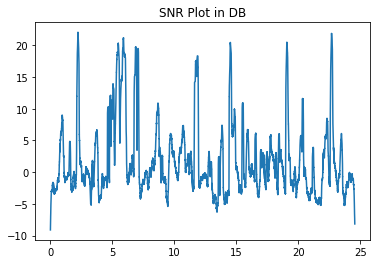

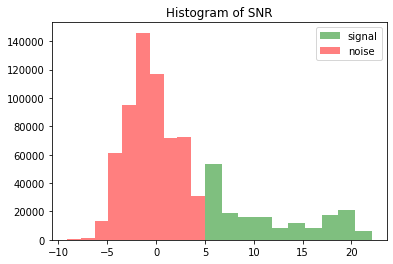

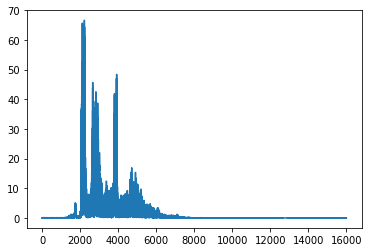

In [8]:
lo_bound=2e3
hi_bound=6.5e3
idx = 29

d = df.data[idx]

r = df.rate[idx]

d = filter_and_detect_call(d, r, SNR_threshold=5, plot=True)

F = np.fft.fft(d)
freq = np.fft.fftfreq(d.shape[0], 1/r)
F = abs(F)[freq > 0]
freq = freq[freq > 0]
plt.plot(freq, F)
plt.show()

ipd.Audio(
    [d, d], rate=r
)

In [9]:
import pickle
import re

preloaded_path = 'HQ_extracted_birdcalls_crop30sec/'
NUM_RECORDS = 50

if os.path.exists(preloaded_path):
    print("Loading calls from file")
    total_num_records = pd.Series(os.listdir(preloaded_path)).apply(lambda x: int(re.search("_([\d]+)\.", x).group(1))).max()
    a = []
    for i in tqdm(np.arange(0, total_num_records, NUM_RECORDS)):
        out_fp = os.path.join(preloaded_path, f"{i}_{i+NUM_RECORDS}.pkl")
        with open(out_fp, 'rb') as f:
            part = pickle.load(f)
            a += part
            print(out_fp, "loaded")
    extracted_calls = pd.Series(a)
    print("Loaded Succesfully!")
    
else:
    # extract bird calls
    os.mkdir(preloaded_path)
    print("Extracting calls from dataframe")
    extracted_calls = df.data.progress_apply(lambda d:
        filter_and_detect_call(d, r, lo_bound=lo_bound, hi_bound=hi_bound, order=5)
    )
    # save to parts
    calls_to_list = extracted_calls.to_list()
    for i in tqdm(np.arange(0, len(extracted_calls), NUM_RECORDS)):
        out_fp = os.path.join(preloaded_path, f"{i}_{i+NUM_RECORDS}.pkl")
        with open(out_fp, 'wb') as f:
            pickle.dump(calls_to_list[i:i+NUM_RECORDS], f)
            print(out_fp, "saved")

Loading calls from file


  1%|▏         | 1/68 [00:00<00:14,  4.52it/s]

HQ_extracted_birdcalls_crop30sec/0_50.pkl loaded


  3%|▎         | 2/68 [00:00<00:30,  2.13it/s]

HQ_extracted_birdcalls_crop30sec/50_100.pkl loaded


  4%|▍         | 3/68 [00:01<00:40,  1.60it/s]

HQ_extracted_birdcalls_crop30sec/100_150.pkl loaded


  6%|▌         | 4/68 [00:02<00:38,  1.68it/s]

HQ_extracted_birdcalls_crop30sec/150_200.pkl loaded


  7%|▋         | 5/68 [00:02<00:37,  1.66it/s]

HQ_extracted_birdcalls_crop30sec/200_250.pkl loaded


  9%|▉         | 6/68 [00:03<00:38,  1.61it/s]

HQ_extracted_birdcalls_crop30sec/250_300.pkl loaded


 10%|█         | 7/68 [00:04<00:40,  1.52it/s]

HQ_extracted_birdcalls_crop30sec/300_350.pkl loaded


 12%|█▏        | 8/68 [00:04<00:39,  1.51it/s]

HQ_extracted_birdcalls_crop30sec/350_400.pkl loaded


 13%|█▎        | 9/68 [00:05<00:38,  1.53it/s]

HQ_extracted_birdcalls_crop30sec/400_450.pkl loaded


 15%|█▍        | 10/68 [00:06<00:37,  1.57it/s]

HQ_extracted_birdcalls_crop30sec/450_500.pkl loaded


 16%|█▌        | 11/68 [00:07<00:42,  1.33it/s]

HQ_extracted_birdcalls_crop30sec/500_550.pkl loaded


 18%|█▊        | 12/68 [00:08<00:50,  1.10it/s]

HQ_extracted_birdcalls_crop30sec/550_600.pkl loaded


 19%|█▉        | 13/68 [00:09<00:57,  1.05s/it]

HQ_extracted_birdcalls_crop30sec/600_650.pkl loaded


 21%|██        | 14/68 [00:11<00:59,  1.11s/it]

HQ_extracted_birdcalls_crop30sec/650_700.pkl loaded


 22%|██▏       | 15/68 [00:12<00:56,  1.07s/it]

HQ_extracted_birdcalls_crop30sec/700_750.pkl loaded


 24%|██▎       | 16/68 [00:12<00:52,  1.00s/it]

HQ_extracted_birdcalls_crop30sec/750_800.pkl loaded


 25%|██▌       | 17/68 [00:14<00:58,  1.15s/it]

HQ_extracted_birdcalls_crop30sec/800_850.pkl loaded


 26%|██▋       | 18/68 [00:15<00:58,  1.17s/it]

HQ_extracted_birdcalls_crop30sec/850_900.pkl loaded


 28%|██▊       | 19/68 [00:16<00:52,  1.08s/it]

HQ_extracted_birdcalls_crop30sec/900_950.pkl loaded


 29%|██▉       | 20/68 [00:17<00:53,  1.12s/it]

HQ_extracted_birdcalls_crop30sec/950_1000.pkl loaded
HQ_extracted_birdcalls_crop30sec/1000_1050.pkl loaded


 32%|███▏      | 22/68 [00:21<01:04,  1.40s/it]

HQ_extracted_birdcalls_crop30sec/1050_1100.pkl loaded
HQ_extracted_birdcalls_crop30sec/1100_1150.pkl loaded


 35%|███▌      | 24/68 [00:24<01:12,  1.65s/it]

HQ_extracted_birdcalls_crop30sec/1150_1200.pkl loaded
HQ_extracted_birdcalls_crop30sec/1200_1250.pkl loaded


 37%|███▋      | 25/68 [00:26<01:17,  1.80s/it]

HQ_extracted_birdcalls_crop30sec/1250_1300.pkl loaded


 40%|███▉      | 27/68 [00:31<01:26,  2.10s/it]

HQ_extracted_birdcalls_crop30sec/1300_1350.pkl loaded


 41%|████      | 28/68 [00:32<01:15,  1.89s/it]

HQ_extracted_birdcalls_crop30sec/1350_1400.pkl loaded


 43%|████▎     | 29/68 [00:33<01:00,  1.55s/it]

HQ_extracted_birdcalls_crop30sec/1400_1450.pkl loaded
HQ_extracted_birdcalls_crop30sec/1450_1500.pkl loaded


 46%|████▌     | 31/68 [00:44<02:19,  3.77s/it]

HQ_extracted_birdcalls_crop30sec/1500_1550.pkl loaded


 47%|████▋     | 32/68 [00:48<02:20,  3.91s/it]

HQ_extracted_birdcalls_crop30sec/1550_1600.pkl loaded


 49%|████▊     | 33/68 [00:53<02:24,  4.12s/it]

HQ_extracted_birdcalls_crop30sec/1600_1650.pkl loaded


 50%|█████     | 34/68 [00:59<02:43,  4.82s/it]

HQ_extracted_birdcalls_crop30sec/1650_1700.pkl loaded


 51%|█████▏    | 35/68 [01:03<02:23,  4.36s/it]

HQ_extracted_birdcalls_crop30sec/1700_1750.pkl loaded


 53%|█████▎    | 36/68 [01:07<02:23,  4.48s/it]

HQ_extracted_birdcalls_crop30sec/1750_1800.pkl loaded


 54%|█████▍    | 37/68 [01:08<01:45,  3.42s/it]

HQ_extracted_birdcalls_crop30sec/1800_1850.pkl loaded


 56%|█████▌    | 38/68 [01:10<01:23,  2.80s/it]

HQ_extracted_birdcalls_crop30sec/1850_1900.pkl loaded


 57%|█████▋    | 39/68 [01:10<01:02,  2.17s/it]

HQ_extracted_birdcalls_crop30sec/1900_1950.pkl loaded


 59%|█████▉    | 40/68 [01:11<00:46,  1.68s/it]

HQ_extracted_birdcalls_crop30sec/1950_2000.pkl loaded


 60%|██████    | 41/68 [01:12<00:38,  1.42s/it]

HQ_extracted_birdcalls_crop30sec/2000_2050.pkl loaded


 62%|██████▏   | 42/68 [01:12<00:31,  1.20s/it]

HQ_extracted_birdcalls_crop30sec/2050_2100.pkl loaded


 63%|██████▎   | 43/68 [01:13<00:27,  1.09s/it]

HQ_extracted_birdcalls_crop30sec/2100_2150.pkl loaded


 65%|██████▍   | 44/68 [01:14<00:23,  1.04it/s]

HQ_extracted_birdcalls_crop30sec/2150_2200.pkl loaded


 66%|██████▌   | 45/68 [01:15<00:21,  1.07it/s]

HQ_extracted_birdcalls_crop30sec/2200_2250.pkl loaded


 68%|██████▊   | 46/68 [01:16<00:20,  1.08it/s]

HQ_extracted_birdcalls_crop30sec/2250_2300.pkl loaded


 69%|██████▉   | 47/68 [01:16<00:18,  1.11it/s]

HQ_extracted_birdcalls_crop30sec/2300_2350.pkl loaded


 71%|███████   | 48/68 [01:17<00:16,  1.23it/s]

HQ_extracted_birdcalls_crop30sec/2350_2400.pkl loaded


 72%|███████▏  | 49/68 [01:18<00:14,  1.27it/s]

HQ_extracted_birdcalls_crop30sec/2400_2450.pkl loaded


 74%|███████▎  | 50/68 [01:19<00:16,  1.10it/s]

HQ_extracted_birdcalls_crop30sec/2450_2500.pkl loaded


 75%|███████▌  | 51/68 [01:20<00:18,  1.08s/it]

HQ_extracted_birdcalls_crop30sec/2500_2550.pkl loaded


 76%|███████▋  | 52/68 [01:22<00:20,  1.26s/it]

HQ_extracted_birdcalls_crop30sec/2550_2600.pkl loaded


 78%|███████▊  | 53/68 [01:25<00:25,  1.73s/it]

HQ_extracted_birdcalls_crop30sec/2600_2650.pkl loaded
HQ_extracted_birdcalls_crop30sec/2650_2700.pkl loaded


 81%|████████  | 55/68 [01:30<00:27,  2.13s/it]

HQ_extracted_birdcalls_crop30sec/2700_2750.pkl loaded
HQ_extracted_birdcalls_crop30sec/2750_2800.pkl loaded


 84%|████████▍ | 57/68 [01:36<00:29,  2.66s/it]

HQ_extracted_birdcalls_crop30sec/2800_2850.pkl loaded
HQ_extracted_birdcalls_crop30sec/2850_2900.pkl loaded


 87%|████████▋ | 59/68 [01:41<00:23,  2.66s/it]

HQ_extracted_birdcalls_crop30sec/2900_2950.pkl loaded
HQ_extracted_birdcalls_crop30sec/2950_3000.pkl loaded


 90%|████████▉ | 61/68 [01:49<00:22,  3.15s/it]

HQ_extracted_birdcalls_crop30sec/3000_3050.pkl loaded


 91%|█████████ | 62/68 [01:51<00:17,  2.85s/it]

HQ_extracted_birdcalls_crop30sec/3050_3100.pkl loaded
HQ_extracted_birdcalls_crop30sec/3100_3150.pkl loaded


 94%|█████████▍| 64/68 [01:57<00:11,  3.00s/it]

HQ_extracted_birdcalls_crop30sec/3150_3200.pkl loaded


 96%|█████████▌| 65/68 [02:00<00:08,  2.79s/it]

HQ_extracted_birdcalls_crop30sec/3200_3250.pkl loaded


 97%|█████████▋| 66/68 [02:02<00:05,  2.77s/it]

HQ_extracted_birdcalls_crop30sec/3250_3300.pkl loaded


 99%|█████████▊| 67/68 [02:04<00:02,  2.49s/it]

HQ_extracted_birdcalls_crop30sec/3300_3350.pkl loaded


100%|██████████| 68/68 [02:07<00:00,  1.87s/it]

HQ_extracted_birdcalls_crop30sec/3350_3400.pkl loaded


Loaded Succesfully!


In [10]:
x = extracted_calls[~extracted_calls.isna()].iloc[650]
ipd.Audio([x, x], rate=r)

In [11]:
tax_df = pd.read_csv('eBird_Taxonomy_v2021.csv')
tax_df.head()

TAXON_ORDER CATEGORY SPECIES_CODE       PRIMARY_COM_NAME  \
0            1  species      ostric2         Common Ostrich   
1            6  species      ostric3         Somali Ostrich   
2            7    slash       y00934  Common/Somali Ostrich   
3            8  species      grerhe1           Greater Rhea   
4           14  species      lesrhe2            Lesser Rhea   

                         SCI_NAME            ORDER1  \
0                Struthio camelus  Struthioniformes   
1          Struthio molybdophanes  Struthioniformes   
2  Struthio camelus/molybdophanes  Struthioniformes   
3                  Rhea americana        Rheiformes   
4                    Rhea pennata        Rheiformes   

                      FAMILY SPECIES_GROUP REPORT_AS  
0  Struthionidae (Ostriches)     Ostriches       NaN  
1  Struthionidae (Ostriches)           NaN       NaN  
2  Struthionidae (Ostriches)           NaN       NaN  
3            Rheidae (Rheas)         Rheas       NaN  
4            Rheidae (Rheas)           NaN       NaN

In [12]:
joined_df = df.join(tax_df.set_index('SPECIES_CODE'), on='SPECIES_CODE')
min_length = joined_df.data.apply(len).min()
joined_df['truncated_data'] = joined_df.data.apply(lambda x: x[:min_length].astype(np.float16))

In [13]:
joined_df.head()

data   rate  latitude  \
0  [-6.028428742865799e-06, 1.5520170109084575e-0...  32000    4.3906   
1  [1.3838414361089235e-06, -1.1788913070631679e-...  32000   -2.9524   
2  [-2.8604351882677292e-06, -4.836467269342393e-...  32000   -2.9524   
3  [3.636400379036786e-06, -5.512704319698969e-06...  32000   -4.0904   
4  [-2.775693701551063e-06, 7.646213816769887e-06...  32000   -4.0904   

   longitude SPECIES_CODE                              path  TAXON_ORDER  \
0    38.2788      abethr1  train_audio/abethr1/XC128013.ogg        27584   
1    38.2921      abethr1  train_audio/abethr1/XC363503.ogg        27584   
2    38.2921      abethr1  train_audio/abethr1/XC363504.ogg        27584   
3    37.8807      abethr1  train_audio/abethr1/XC467121.ogg        27584   
4    37.8807      abethr1  train_audio/abethr1/XC467122.ogg        27584   

  CATEGORY          PRIMARY_COM_NAME            SCI_NAME         ORDER1  \
0  species  African Bare-eyed Thrush  Turdus tephronotus  Passeriformes   
1  species  African Bare-eyed Thrush  Turdus tephronotus  Passeriformes   
2  species  African Bare-eyed Thrush  Turdus tephronotus  Passeriformes   
3  species  African Bare-eyed Thrush  Turdus tephronotus  Passeriformes   
4  species  African Bare-eyed Thrush  Turdus tephronotus  Passeriformes   

                           FAMILY SPECIES_GROUP REPORT_AS  \
0  Turdidae (Thrushes and Allies)           NaN       NaN   
1  Turdidae (Thrushes and Allies)           NaN       NaN   
2  Turdidae (Thrushes and Allies)           NaN       NaN   
3  Turdidae (Thrushes and Allies)           NaN       NaN   
4  Turdidae (Thrushes and Allies)           NaN       NaN   

                                      truncated_data  
0  [-6e-06, 1.55e-06, -9.5e-07, 3.2e-06, -1.127e-...  
1  [1.4e-06, -1.18e-05, 1.055e-05, -2.2e-06, 3.34...  
2  [-2.86e-06, -4.8e-06, -1.9e-06, -1.67e-06, 3.2...  
3  [3.64e-06, -5.5e-06, 5.84e-06, 1.603e-05, -2.5...  
4  [-2.8e-06, 7.6e-06, -3e-07, 4.35e-06, -1.2e-06...

# Get PCA in Time Domain

In [14]:
data = np.vstack(joined_df.truncated_data.to_numpy())
pca_length=800
e_vals, e_vecs = np.linalg.eig(np.cov(data[:, :pca_length].astype(float).T))
e_vecs = abs(e_vecs)

In [15]:
import plotly.graph_objects as go
fig = go.Figure()

for code in joined_df.SPECIES_CODE.unique():
    sub_df = joined_df[joined_df.SPECIES_CODE==code]
    X = np.vstack(sub_df.truncated_data.to_numpy())[:, :pca_length]
    P = np.matmul(X, e_vecs[:, :3])
    fig.add_trace(go.Scatter3d(
        x = P.T[0],
        y = P.T[1],
        z = P.T[2],
        mode='markers',
        name=code,
        marker=dict(symbol='diamond-open', opacity=0.8)
    ))
    
fig.show()

In [16]:
fig = go.Figure()

for order in joined_df.ORDER1.unique():
    sub_df = joined_df[joined_df.ORDER1==order]
    X = np.vstack(sub_df.truncated_data.to_numpy())[:, :pca_length]
    P = np.matmul(X, e_vecs[:, :3])
    fig.add_trace(go.Scatter3d(
        x = P.T[0],
        y = P.T[1],
        z = P.T[2],
        mode='markers',
        name=order,
        marker=dict(symbol='diamond-open', opacity=0.8)
    ))
    
fig.show()

In [17]:
FFTs = extracted_calls[~extracted_calls.isna()].progress_apply(get_freq_feats)

  0%|          | 0/3177 [00:00<?, ?it/s]C:\Users\augus\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: RuntimeWarning:

Mean of empty slice.

100%|██████████| 3177/3177 [06:27<00:00,  8.19it/s]


In [18]:
freq_data = np.nan_to_num(np.vstack(FFTs), 0)

e_vals_fft, e_vecs_fft = np.linalg.eig(np.cov(freq_data.T))

In [19]:
fig = go.Figure()

for order in joined_df.ORDER1.unique():
    X = freq_data[joined_df[~extracted_calls.isna()].ORDER1==order]
    P = np.matmul(X, e_vecs_fft[:, :2])
    fig.add_trace(go.Scatter(
        x = P.T[0],
        y = P.T[1],
#         z = P.T[2],
        mode='markers',
        name=order,
        marker=dict(symbol='x')
    ))
    
fig.show()

In [20]:
top4 = meta_df.primary_label.value_counts()[:4].index
in_top4 = pd.merge(meta_df[['primary_label']], tax_df, left_on='primary_label', right_on='SPECIES_CODE').primary_label.isin(top4)
top3 = pd.merge(meta_df[['primary_label']], tax_df, left_on='primary_label', right_on='SPECIES_CODE').FAMILY.value_counts()[:3].index
in_top3 = pd.merge(meta_df[['primary_label']], tax_df, left_on='primary_label', right_on='SPECIES_CODE').FAMILY.isin(top3)

In [21]:
# ret2 = meta_df[in_top3].sample(500, random_state=2).progress_apply(lambda x: load_signal(x), axis=1)
df2 = df[(in_top4) & (~extracted_calls.isna())]#pd.DataFrame(list(ret2))
display(df2)
# extracted_calls2 = df2.data.progress_apply(lambda d:
#     filter_and_detect_call(d, r)
# )

data   rate  latitude  \
234   [8.55841122415768e-08, -2.947666416730499e-06,...  32000   35.0307   
235   [-7.045950383144373e-07, 1.7351763972328627e-0...  32000   51.4226   
236   [-5.127026270201895e-06, 6.093207048252225e-06...  32000   35.0620   
237   [5.762150067312177e-06, 1.817386146285571e-05,...  32000   30.0801   
238   [8.582029309422978e-09, 2.072990127999219e-06,...  32000   51.0383   
...                                                 ...    ...       ...   
3144  [-1.286626456931117e-06, -4.069169790454907e-0...  32000   51.4279   
3145  [1.0823051752595347e-06, 2.1795235625177156e-0...  32000  -33.2946   
3146  [-5.731825694965664e-06, 2.111493131451425e-06...  32000   52.1390   
3147  [-6.350168035851311e-08, -2.24365726353426e-06...  32000   52.1390   
3148  [4.212714884488378e-06, -2.0943928120686905e-0...  32000   52.3031   

      longitude SPECIES_CODE                             path  
234   -120.6205       barswa  train_audio/barswa/XC129647.ogg  
235     23.1201       barswa  train_audio/barswa/XC134349.ogg  
236    -85.1660       barswa  train_audio/barswa/XC135474.ogg  
237    -99.5027       barswa  train_audio/barswa/XC141346.ogg  
238      3.9184       barswa  train_audio/barswa/XC142794.ogg  
...         ...          ...                              ...  
3144     5.4685       wlwwar  train_audio/wlwwar/XC679888.ogg  
3145    26.5104       wlwwar  train_audio/wlwwar/XC685552.ogg  
3146    -8.6539       wlwwar  train_audio/wlwwar/XC687548.ogg  
3147    -8.6539       wlwwar  train_audio/wlwwar/XC687549.ogg  
3148    -8.5386       wlwwar  train_audio/wlwwar/XC687572.ogg  

[718 rows x 6 columns]

In [22]:
joined_df2 = df2.join(tax_df.set_index('SPECIES_CODE'), on='SPECIES_CODE')

In [23]:
FFTs2 = extracted_calls[(in_top4) & (~extracted_calls.isna())].progress_apply(get_freq_feats, args=(200,))#extracted_calls2[~extracted_calls2.isna()].progress_apply(get_freq_feats, args=(200,))

  0%|          | 0/718 [00:00<?, ?it/s]C:\Users\augus\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: RuntimeWarning:

Mean of empty slice.

100%|██████████| 718/718 [01:54<00:00,  6.27it/s]


In [24]:
freq_data2 = np.nan_to_num(np.vstack(FFTs2), 0)
e_vals_fft2, e_vecs_fft2 = np.linalg.eig(np.cov(freq_data2.T))

In [36]:
fig = go.Figure()
symbols = ['circle', 'x', 'diamond', 'square']
for i, order in enumerate(joined_df2.SPECIES_CODE.unique()):
    X = freq_data2[joined_df2.SPECIES_CODE==order]
    P = np.matmul(X, e_vecs_fft2[:, :3])
    fig.add_trace(go.Scatter3d(
        x = P.T[0],
        y = P.T[1],
        z = P.T[2],
        mode='markers',
        name=str(tax_df[tax_df.SPECIES_CODE==order].PRIMARY_COM_NAME.item()),
        marker=dict(symbol=symbols[i], size=4, opacity=0.6)
    ))
fig.update_layout(showlegend=False)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.show()

In [33]:
fig.write_html('top4_birdclef.html')

In [35]:
joined_df2.sample(4)

data   rate  latitude  \
271   [-2.913836397056002e-06, 2.5845738491625525e-0...  32000   36.4172   
2958  [2.421733552182559e-05, 2.2893471395946108e-05...  32000   48.3062   
2473  [2.4117556677083485e-05, -2.09661629924085e-06...  32000   51.4167   
1458  [5.4704655667592306e-06, -1.6764267911639763e-...  32000   46.3142   

      longitude SPECIES_CODE                              path  TAXON_ORDER  \
271     -6.1459       barswa   train_audio/barswa/XC361221.ogg        23291   
2958    10.9337       wlwwar   train_audio/wlwwar/XC177859.ogg        23981   
2473    17.5667      thrnig1  train_audio/thrnig1/XC198563.ogg        28409   
1458     7.6704       hoopoe   train_audio/hoopoe/XC641484.ogg         9161   

     CATEGORY    PRIMARY_COM_NAME                SCI_NAME          ORDER1  \
271   species        Barn Swallow         Hirundo rustica   Passeriformes   
2958  species      Willow Warbler  Phylloscopus trochilus   Passeriformes   
2473  species  Thrush Nightingale       Luscinia luscinia   Passeriformes   
1458  species     Eurasian Hoopoe             Upupa epops  Bucerotiformes   

                                    FAMILY SPECIES_GROUP REPORT_AS  
271                Hirundinidae (Swallows)           NaN       NaN  
2958        Phylloscopidae (Leaf Warblers)           NaN       NaN  
2473  Muscicapidae (Old World Flycatchers)           NaN       NaN  
1458                    Upupidae (Hoopoes)       Hoopoes       NaN